In [7]:
import scipy.io as scio  #导入scio包
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
import pywt
import pywt.data
import pandas as pd

## 加载读取数据

外圈数据

In [5]:
def DataAcquision(file_Path):
    """
    fun: 从cwru mat文件读取加速度数据
    param file_path: mat文件绝对路径
    return accl_data: 加速度数据，array类型
    """
    data = scio.loadmat(file_path)  # 加载mat数据
    data_key_list = list(data.keys())  # mat文件为字典类型，获取字典所有的键并转换为list类型
    accl_key = data_key_list[3]  # 获取'X108_DE_time'
    accl_data = data[accl_key].flatten()  # 获取'X108_DE_time'所对应的值，即为振动加速度信号,并将二维数组展成一维数组
    return accl_data

file_path = r'E:/研究生/pytorch/CSDN代码/第3篇-小波包能量/1730_12k_0.007-InnerRace.mat'  #文件夹路径
data_arr = DataAcquision(file_path)  # 加载mat数据

wp = pywt.WaveletPacket(data=data_arr, wavelet='db1',mode='symmetric',maxlevel=3) #选用db1小波，分解层数为3

In [11]:
file_path = r'E:/研究生/pytorch/CSDN代码/第3篇-小波包能量/1730_12k_0.007-InnerRace.mat'  #文件夹路径
data_arr = DataAcquision(file_path)  # 加载mat数据
print(data_arr)

[ 0.22269856  0.09323776 -0.14651649 ... -0.36125573  0.31138814
  0.17055689]


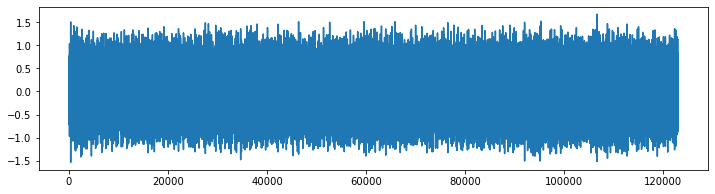

In [19]:
plt.figure(figsize=(12,3))
plt.plot(data)

打印小波家族
常见的 haar db morl

In [14]:
pywt.families()
#pywt.families(short=False)

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

小波只能分解低频，小波能分解低频和高频
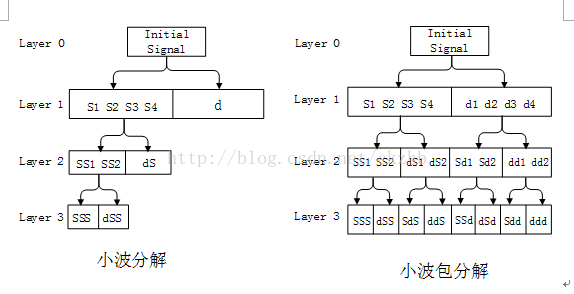

In [15]:
wp = pywt.WaveletPacket(data=data_arr, wavelet='db1',mode='symmetric',maxlevel=3) #选用db1小波，分解层数为3
#根据频段频率（freq）进行排序
print([node.path for node in wp.get_level(1, 'freq')])  # 第一层小波包节点
print([node.path for node in wp.get_level(2, 'freq')])  # 第二层小波包节点
print([node.path for node in wp.get_level(3, 'freq')])  # 第三层小波包节点

['a', 'd']
['aa', 'ad', 'dd', 'da']
['aaa', 'aad', 'add', 'ada', 'dda', 'ddd', 'dad', 'daa']


该方法输入原始信号data_arr， 小波函数'db1'，模式'symmetric'，以及最大的分解层数为3。返回wp是小波包树，根据小波包树我们可以提取分解系数。

提取分解系数：
下面aaa是小波包变换第三层第一个的分解系数

In [32]:
aaa = wp['aaa'].data 
print(aaa)
print('aaa的长度:',aaa.shape[0])
print('data_arr的长度:',data_arr.shape[0])
print('理论上第3层每个分解系数的长度:',data_arr.shape[0]/8)

[ 0.13742877  0.02521155 -0.30747749 ... -0.14569862 -0.28215109
  0.57900413]
aaa的长度: 15365
data_arr的长度: 122917
理论上第3层每个分解系数的长度: 15364.625


## 绘制每一层小波分解时域图

(1) 所以可以使用下面的方法提取每一层的每个节点的小波系数，当然这个方法不太方便，需要一个一个的写，后面有更好的方法：

In [29]:
a = wp['a'].data #第1个节点
d = wp['d'].data #第2个节点
#第二层
aa = wp['aa'].data 
ad = wp['ad'].data 
dd = wp['dd'].data 
da = wp['da'].data 
#第三层
aaa = wp['aaa'].data 
aad = wp['aad'].data 
ada = wp['add'].data 
add = wp['ada'].data 
daa = wp['dda'].data 
dad = wp['ddd'].data 
dda = wp['dad'].data 
ddd = wp['daa'].data 

(2) 做小波图

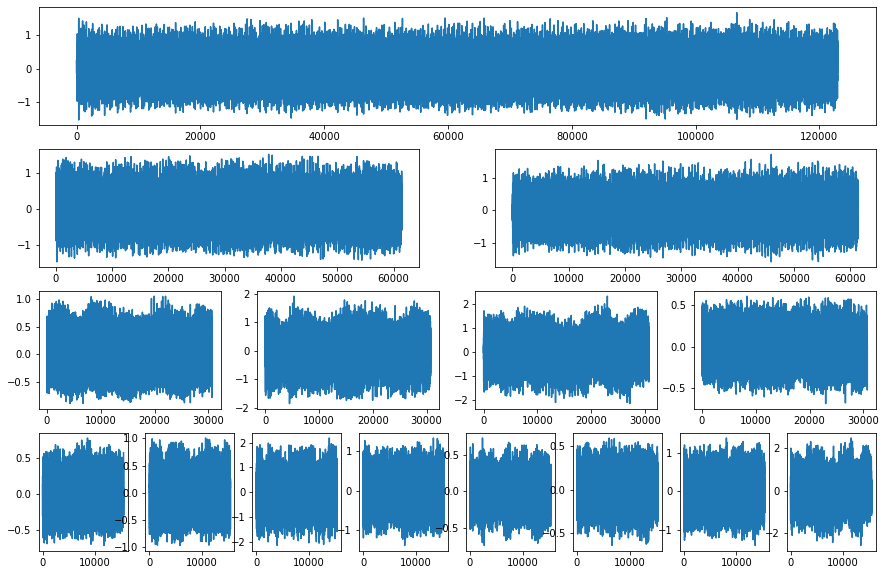

In [36]:
plt.figure(figsize=(15, 10))
plt.subplot(4,1,1)
plt.plot(data_arr)
#第一层
plt.subplot(4,2,3)
plt.plot(a)
plt.subplot(4,2,4)
plt.plot(d)
#第二层
plt.subplot(4,4,9)
plt.plot(aa)
plt.subplot(4,4,10)
plt.plot(ad)
plt.subplot(4,4,11)
plt.plot(dd)
plt.subplot(4,4,12)
plt.plot(da)
#第三层
plt.subplot(4,8,25)
plt.plot(aaa)
plt.subplot(4,8,26)
plt.plot(aad)
plt.subplot(4,8,27)
plt.plot(add)
plt.subplot(4,8,28)
plt.plot(ada)
plt.subplot(4,8,29)
plt.plot(dda)
plt.subplot(4,8,30)
plt.plot(ddd)
plt.subplot(4,8,31)
plt.plot(dad)
plt.subplot(4,8,32)
plt.plot(daa)

(3) 使用的wpd_plt(signal,n)将上面的代码优化和封装了，signal代表输入信号，n代表分解层数：

In [38]:
def wpd_plt(signal,n):
    #wpd分解
    wp = pywt.WaveletPacket(data=signal, wavelet='db1',mode='symmetric',maxlevel=n)
 
    #计算每一个节点的系数，存在map中，key为'aa'等，value为列表
    map = {}
    map[1] = signal
    for row in range(1,n+1):
        lev = []
        for i in [node.path for node in wp.get_level(row, 'freq')]:
            map[i] = wp[i].data
 
    #作图
    plt.figure(figsize=(15, 10))
    plt.subplot(n+1,1,1) #绘制第一个图
    plt.plot(map[1])
    for i in range(2,n+2):
        level_num = pow(2,i-1)  #从第二行图开始，计算上一行图的2的幂次方
        #获取每一层分解的node：比如第三层['aaa', 'aad', 'add', 'ada', 'dda', 'ddd', 'dad', 'daa']
        re = [node.path for node in wp.get_level(i-1, 'freq')]  
        for j in range(1,level_num+1):
            plt.subplot(n+1,level_num,level_num*(i-1)+j)
            plt.plot(map[re[j-1]]) #列表从0开始  

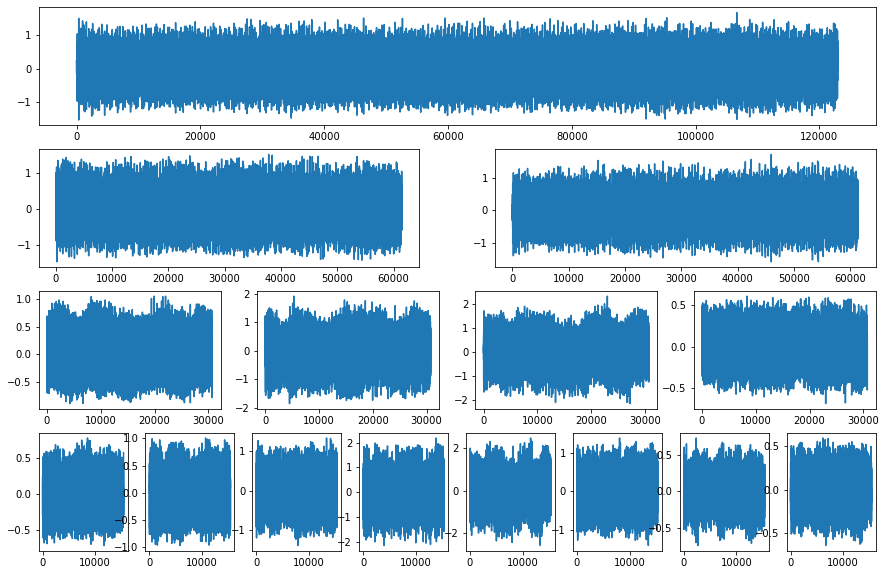

In [49]:
wpd_plt(signal=data_arr, n=3)

## 绘制小波包能量图

In [50]:
def DataAcquision(file_Path):
    """
    fun: 从cwru mat文件读取加速度数据
    param file_path: mat文件绝对路径
    return accl_data: 加速度数据，array类型
    """
    data = scio.loadmat(file_path)  # 加载mat数据
    data_key_list = list(data.keys())  # mat文件为字典类型，获取字典所有的键并转换为list类型
    accl_key = data_key_list[3]  # 获取'X108_DE_time'
    accl_data = data[accl_key].flatten()  # 获取'X108_DE_time'所对应的值，即为振动加速度信号,并将二维数组展成一维数组
    return accl_data

file_path = r'E:/研究生/pytorch/CSDN代码/第3篇-小波包能量/1730_12k_0.007-InnerRace.mat'  #文件夹路径
data_arr = DataAcquision(file_path)  # 加载mat数据

wp = pywt.WaveletPacket(data=data_arr, wavelet='db1',mode='symmetric',maxlevel=3) #选用db1小波，分解层数为3

In [51]:
n = 3
re = []  #第n层所有节点的分解系数
for i in [node.path for node in wp.get_level(n, 'freq')]:
    re.append(wp[i].data)
#第n层能量特征
energy = []
for i in re:
    energy.append(pow(np.linalg.norm(i,ord=None),2))
for i in energy:
    print(i)

601.1287769222096
1166.6942072871639
1574.8261014889372
3020.053424520311
3624.086184449376
1496.5850478295588
317.91754565296947
287.5823913938649


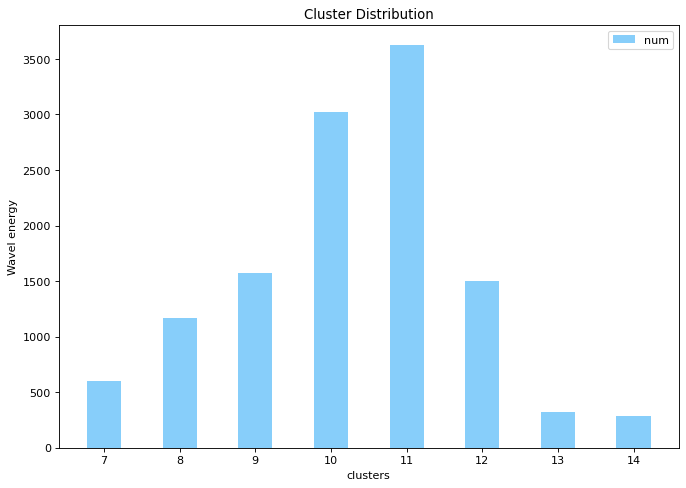

In [52]:
# 创建一个点数为 8 x 6 的窗口, 并设置分辨率为 80像素/每英寸
plt.figure(figsize=(10, 7), dpi=80)
# 再创建一个规格为 1 x 1 的子图
# plt.subplot(1, 1, 1)
# 柱子总数
N = 8
values = energy
# 包含每个柱子下标的序列
index = np.arange(N)
# 柱子的宽度
width = 0.45
# 绘制柱状图, 每根柱子的颜色为紫罗兰色
p2 = plt.bar(index, values, width, label="num", color="#87CEFA")
# 设置横轴标签
plt.xlabel('clusters')
# 设置纵轴标签
plt.ylabel('Wavel energy')
# 添加标题
plt.title('Cluster Distribution')
# 添加纵横轴的刻度
plt.xticks(index, ('7', '8', '9', '10', '11', '12', '13', '14'))
# plt.yticks(np.arange(0, 10000, 10))
# 添加图例
plt.legend(loc="upper right")
plt.show()

关键程序

In [43]:
map = {}
map[1] = data_arr
n = 3
for row in range(1,n+1):
    for i in [node.path for node in wp.get_level(row, 'freq')]:
        print(i)
        map[i] = wp[i].data

a
d
aa
ad
dd
da
aaa
aad
add
ada
dda
ddd
dad
daa


In [44]:
map

{1: array([ 0.22269856,  0.09323776, -0.14651649, ..., -0.36125573,
         0.31138814,  0.17055689]),
 'a': array([ 0.22340072,  0.02170835,  0.12542601, ...,  0.71086224,
        -0.03526171,  0.24120386]),
 'd': array([ 0.09154261, -0.22891395,  0.22604248, ...,  0.47677963,
        -0.47563104,  0.        ]),
 'aa': array([0.17331828, 0.02103535, 0.2048307 , ..., 0.1387196 , 0.47772172,
        0.34111377]),
 'ad': array([ 0.14261804,  0.15634381, -0.01331968, ..., -0.00129948,
         0.5275893 ,  0.        ]),
 'dd': array([ 0.22659701,  0.21352098,  0.01884248, ..., -0.44036164,
         0.67345605,  0.        ]),
 'da': array([-0.09713621,  0.10615136,  0.0300505 , ..., -0.5183305 ,
         0.00081218,  0.        ]),
 'aaa': array([ 0.13742877,  0.02521155, -0.30747749, ..., -0.14569862,
        -0.28215109,  0.57900413]),
 'aad': array([ 0.1076803 ,  0.26446281,  0.54041151, ..., -0.30006909,
        -0.47833023,  0.0965964 ]),
 'add': array([-0.00970558, -0.01039474, -0.33

## 正常状态小波包能量

1021.5168476406585
452.3749624106609
309.1511931365197
142.1466500905686
38.92694236720233
77.92200291274384
45.94133962149062
20.05028055171906


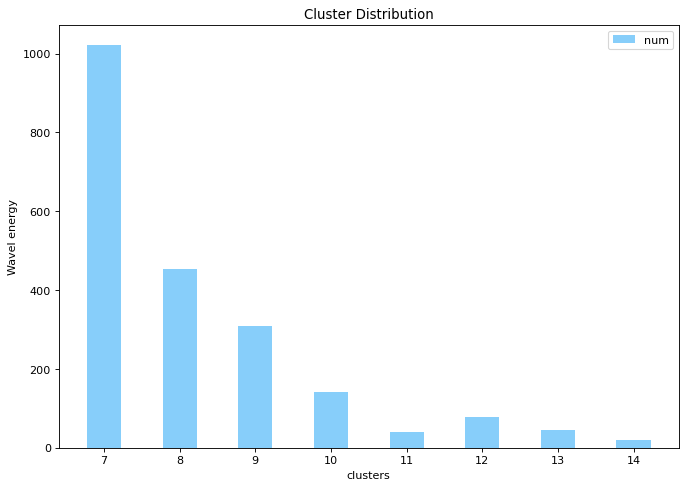

In [55]:
def DataAcquision(file_Path):
    """
    fun: 从cwru mat文件读取加速度数据
    param file_path: mat文件绝对路径
    return accl_data: 加速度数据，array类型
    """
    data = scio.loadmat(file_path)  # 加载mat数据
    data_key_list = list(data.keys())  # mat文件为字典类型，获取字典所有的键并转换为list类型
    accl_key = data_key_list[3]  # 获取'X108_DE_time'
    accl_data = data[accl_key].flatten()  # 获取'X108_DE_time'所对应的值，即为振动加速度信号,并将二维数组展成一维数组
    return accl_data

file_path = r'E:/研究生/pytorch/CSDN代码/第3篇-小波包能量/1730_48k_Normal.mat'  #文件夹路径
data_arr = DataAcquision(file_path)  # 加载mat数据

wp = pywt.WaveletPacket(data=data_arr, wavelet='db1',mode='symmetric',maxlevel=3) #选用db1小波，分解层数为3

#------计算每层小波包能量------#
n = 3
re = []  #第n层所有节点的分解系数
for i in [node.path for node in wp.get_level(n, 'freq')]:
    re.append(wp[i].data)
#第n层能量特征
energy = []
for i in re:
    energy.append(pow(np.linalg.norm(i,ord=None),2))
for i in energy:
    print(i)
    
#-------绘制小波包能量图------——#
# 创建一个点数为 8 x 6 的窗口, 并设置分辨率为 80像素/每英寸
plt.figure(figsize=(10, 7), dpi=80)
# 再创建一个规格为 1 x 1 的子图
# plt.subplot(1, 1, 1)
# 柱子总数
N = 8
values = energy
# 包含每个柱子下标的序列
index = np.arange(N)
# 柱子的宽度
width = 0.45
# 绘制柱状图, 每根柱子的颜色为紫罗兰色
p2 = plt.bar(index, values, width, label="num", color="#87CEFA")
# 设置横轴标签
plt.xlabel('clusters')
# 设置纵轴标签
plt.ylabel('Wavel energy')
# 添加标题
plt.title('Cluster Distribution')
# 添加纵横轴的刻度
plt.xticks(index, ('7', '8', '9', '10', '11', '12', '13', '14'))
# plt.yticks(np.arange(0, 10000, 10))
# 添加图例
plt.legend(loc="upper right")
plt.show()